In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn import preprocessing
import xgboost
from xgboost import XGBClassifier
import shap
import seaborn as sns
import yaml
import joblib
import requests
import warnings
warnings.filterwarnings("ignore") 

# from scripts.check_overlaps import check_overlaps
# from make_dataset import make_dataset_censored,  make_dataset_uncensored, repeat_masker, COSMIC_CGC_interactions, TF_binding_site_annotations, create_vep_input, read_vcf, long_range_interactions_results, create_vep_input, read_vcf, clean_and_preprocess
from scripts.read_test_data import read_test_data
from scripts.calculate_end_coordinates import calculate_end_coordinates
from scripts.read_icgc_tcga_data import read_ICGC_TCGA_data
from scripts.create_vep_input import create_vep_input
from RepeatMasker.repeatmasker import call_repeatmasker
from COSMIC_CGC_Interactions.gene_interactions import find_cosmic_cgc_overlaps
from lncRNA.lncrna import find_lncrna_overlaps
from TF_binding_Effect_Prediction.TF_prediction_generator import generate_TF_predictions
from Long_Range_Interactions.combining_results import long_range_interactions_results

with open("configuration.yaml", "r") as yml_file:
    config = yaml.load(yml_file, yaml.Loader)

c:\ProgramData\anaconda3\envs\ensemble\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\ProgramData\anaconda3\envs\ensemble\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(

In [ ]:
testdf = read_test_data()

negdf = pd.read_csv('data/nondriver_noncoding_mutations.vcf', sep='\t', header=None) #negative_samples.vcf
negdf.columns=['chr', 'start', 'ref', 'alt']
negdf['data_source'] = 'COSMIC'
negdf = negdf[['chr', 'start', 'ref', 'alt', 'data_source']]
negdf['start'] = negdf['start'].apply(lambda x: int(x))
negdf['driver'] = 0
negdf = negdf[negdf['chr'] != 'MT'].reset_index(drop=True)

posdf = read_ICGC_TCGA_data()
traindf = pd.concat([negdf, posdf]).reset_index(drop=True)
traindf = calculate_end_coordinates(traindf)
traindf['id'] = 'mut' + traindf.index.astype(str)

testdf['check'] = testdf[['chr', 'start', 'ref', 'alt']].apply(tuple, axis=1).isin(traindf[['chr', 'start', 'ref', 'alt']].apply(tuple, axis=1))
testdf = testdf[testdf['check'] == False].reset_index(drop=True)
testdf.drop('check', inplace=True, axis = 1)
testdf['id'] = 'test' + testdf.index.astype(str)

In [23]:
df = pd.concat([traindf, testdf]).reset_index(drop=True)
df = df[['id', 'chr', 'start', 'end', 'ref', 'alt', 'driver', 'data_source']]
df

,id,chr,start,end,ref,alt,driver,data_source
0,mut0,16,731865,731865,C,T,0,COSMIC
1,mut1,10,51622545,51622545,G,T,0,COSMIC
2,mut2,22,50945191,50945191,T,C,0,COSMIC
3,mut3,5,149829722,149829722,G,T,0,COSMIC
4,mut4,22,45128174,45128174,G,A,0,COSMIC
...,...,...,...,...,...,...,...,...
3097,test1116,9,125026995,125026996,C,G,1,Dr.Nod 2023
3098,test1117,9,124049461,124049462,T,A,1,Dr.Nod 2023
3099,test1118,X,70338403,70338404,G,A,1,Dr.Nod 2023
3100,test1119,X,70401837,70401838,G,T,1,Dr.Nod 2023


In [15]:
# df.to_csv('data/all_data.csv', index=False)
df = pd.read_csv('data/all_data.csv')
df

,id,chr,start,end,ref,alt,driver,data_source
0,mut0,16,731865,731865,C,T,0,COSMIC
1,mut1,10,51622545,51622545,G,T,0,COSMIC
2,mut2,22,50945191,50945191,T,C,0,COSMIC
3,mut3,5,149829722,149829722,G,T,0,COSMIC
4,mut4,22,45128174,45128174,G,A,0,COSMIC
...,...,...,...,...,...,...,...,...
3097,test1116,9,125026995,125026996,C,G,1,Dr.Nod 2023
3098,test1117,9,124049461,124049462,T,A,1,Dr.Nod 2023
3099,test1118,X,70338403,70338404,G,A,1,Dr.Nod 2023
3100,test1119,X,70401837,70401838,G,T,1,Dr.Nod 2023


In [60]:
# df = pd.read_csv('data/all_data.csv')
# df = df[:15]
# df = call_repeatmasker(df)
# df = find_cosmic_cgc_overlaps(df)
# df = find_lncrna_overlaps(df)
# df = long_range_interactions_results(df)
df = generate_TF_predictions(df, 'hg19', 0.001)

1- Bed file is created!
2- Fasta file is created!
3- VEP file with sequences is created!
Prediction Starting!

Analyzing VEP file | ENCODE_ID: ENCFF030DLI, TF_name: CREB1
Analyzing VEP file finished in 12.791 s | ENCODE_ID: ENCFF030DLI, TF_name: CREB1

Analyzing VEP file | ENCODE_ID: ENCFF099RDJ, TF_name: PKNOX1
Analyzing VEP file finished in 15.106 s | ENCODE_ID: ENCFF099RDJ, TF_name: PKNOX1

Analyzing VEP file | ENCODE_ID: ENCFF107DBQ, TF_name: ATF3
Analyzing VEP file finished in 14.94 s | ENCODE_ID: ENCFF107DBQ, TF_name: ATF3

Analyzing VEP file | ENCODE_ID: ENCFF115KRO, TF_name: E2F1
Analyzing VEP file finished in 13.781 s | ENCODE_ID: ENCFF115KRO, TF_name: E2F1

Analyzing VEP file | ENCODE_ID: ENCFF155KUW, TF_name: REST
Analyzing VEP file finished in 13.738 s | ENCODE_ID: ENCFF155KUW, TF_name: REST

Analyzing VEP file | ENCODE_ID: ENCFF186VMW, TF_name: STAT1
Analyzing VEP file finished in 13.752 s | ENCODE_ID: ENCFF186VMW, TF_name: STAT1

Analyzing VEP file | ENCODE_ID: ENCFF201LF

In [7]:
df

,chr,start,ref,alt,id,end,driver,data_source,DNA,LINE,...,CTCF_loops,POLR2A_loops,CTCF_intervals,POLR2A_intervals,CTCF_overlaps,POLR2A_overlaps,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff
0,1,1052729,T,A,mut1341,1052729,0,COSMIC,0,0,...,0.125952,0.061633,0.135020,0.082103,0.088380,0.050502,0,0,0.00000,0.000000
1,1,1227399,G,A,mut1578,1227399,0,COSMIC,0,0,...,0.150913,0.084082,0.168619,0.113026,0.108987,0.069274,1,0,1.92169,0.000000
2,1,1234820,C,G,mut974,1234820,0,COSMIC,0,0,...,0.064409,0.010543,0.068040,0.016398,0.044907,0.009749,0,1,0.00000,0.954938
3,1,1256438,C,T,mut1462,1256438,0,COSMIC,0,0,...,0.040629,0.043394,0.043214,0.055852,0.028367,0.034663,0,0,0.00000,0.000000
4,1,1342375,A,G,mut456,1342375,0,COSMIC,0,0,...,0.102594,0.085754,0.109910,0.116098,0.072060,0.071111,0,0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097,X,153006175,T,G,mut255,153006175,0,COSMIC,0,0,...,0.004272,0.000291,0.007780,0.000738,0.004435,0.000407,0,0,0.00000,0.000000
3098,X,153174592,C,T,mut1330,153174592,0,COSMIC,0,0,...,0.013151,0.003976,0.021500,0.008260,0.012531,0.004672,0,0,0.00000,0.000000
3099,X,153207408,T,G,mut1282,153207408,0,COSMIC,0,0,...,0.010127,0.002354,0.017020,0.004375,0.009875,0.002521,0,0,0.00000,0.000000
3100,X,153698355,C,T,mut738,153698355,0,COSMIC,0,0,...,0.000860,0.003871,0.001303,0.007915,0.000767,0.004480,0,0,0.00000,0.000000


In [18]:
# df.to_csv('data/extracted_data.csv', index = False)
df = pd.read_csv('data/extracted_data.csv')
# df = df[df['chr'] != 'MT'].reset_index(drop=True)

Creating the input file for VEP<br>
This file is then given to Ensembl VEP <br>
We used the web version: https://grch37.ensembl.org/Homo_sapiens/Tools/VEP/<br>
Make sure you are using the Grch37 version

In [3]:
vepdf = create_vep_input(df, "data/VEP/vep_input.vcf")
vepdf

File format detected that is other than VCF. Converting 153 records to VCF now...
This may take some time...


,chr,start,id,ref,alt,qual,filter,info,format
1341,1,1052729,mut1341,T,A,.,.,.,.
1578,1,1227399,mut1578,G,A,.,.,.,.
974,1,1234820,mut974,C,G,.,.,.,.
1462,1,1256438,mut1462,C,T,.,.,.,.
456,1,1342375,mut456,A,G,.,.,.,.
...,...,...,...,...,...,...,...,...,...
255,X,153006175,mut255,T,G,.,.,.,.
1330,X,153174592,mut1330,C,T,.,.,.,.
1282,X,153207408,mut1282,T,G,.,.,.,.
738,X,153698355,mut738,C,T,.,.,.,.


Reading VEP output<br>
The file generated by Ensembl VEP is downloaded (in .txt format) and used

In [19]:
# df_vep_output = read_vcf('data/VEP/vep_output.txt')
import io
def read_vcf(path):
    """Reads a VCF format text file"""
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    df = pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})
    return df
vep_output= read_vcf('data/VEP/vep_output.txt')
vep_output

,#Uploaded_variation,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,Feature,BIOTYPE,...,MaxEntScan_ref,PHENOTYPES,IntAct_ap_ac,IntAct_feature_ac,IntAct_feature_annotation,IntAct_feature_short_label,IntAct_feature_type,IntAct_interaction_ac,IntAct_interaction_participants,IntAct_pmid
0,mut456,1:1342375-1342375,G,missense_variant,MODERATE,MRPL20,ENSG00000242485,Transcript,ENST00000344843.7,protein_coding,...,-,-,-,-,-,-,-,-,-,-
1,mut456,1:1342375-1342375,G,downstream_gene_variant,MODIFIER,RP4-758J18.2,ENSG00000224870,Transcript,ENST00000418833.2,retained_intron,...,-,-,-,-,-,-,-,-,-,-
2,mut456,1:1342375-1342375,G,downstream_gene_variant,MODIFIER,RP4-758J18.2,ENSG00000224870,Transcript,ENST00000444362.1,protein_coding,...,-,-,-,-,-,-,-,-,-,-
3,mut456,1:1342375-1342375,G,downstream_gene_variant,MODIFIER,RP4-758J18.2,ENSG00000224870,Transcript,ENST00000447725.2,nonsense_mediated_decay,...,-,-,-,-,-,-,-,-,-,-
4,mut456,1:1342375-1342375,G,downstream_gene_variant,MODIFIER,RP4-758J18.2,ENSG00000224870,Transcript,ENST00000453521.1,processed_transcript,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28488,mut738,X:153698355-153698355,T,downstream_gene_variant,MODIFIER,PLXNA3,ENSG00000130827,Transcript,ENST00000480645.1,processed_transcript,...,-,-,-,-,-,-,-,-,-,-
28489,mut738,X:153698355-153698355,T,downstream_gene_variant,MODIFIER,PLXNA3,ENSG00000130827,Transcript,ENST00000491066.1,retained_intron,...,-,-,-,-,-,-,-,-,-,-
28490,mut738,X:153698355-153698355,T,non_coding_transcript_exon_variant,MODIFIER,PLXNA3,ENSG00000130827,Transcript,ENST00000493546.1,processed_transcript,...,-,-,-,-,-,-,-,-,-,-
28491,mut738,X:153698355-153698355,T,upstream_gene_variant,MODIFIER,PLXNA3,ENSG00000130827,Transcript,ENST00000497802.1,retained_intron,...,-,-,-,-,-,-,-,-,-,-


In [60]:
vep_output.to_csv('data/VEP/vep_outout.csv', index=False)#[vep_output['#Uploaded_variation'] == 'mut2068']

In [ ]:
for c in df_vep_output_test.columns:
    print(c)
# df_vep_output_test[['gnomAD_genomes_AF']].value_counts()

Clean and preprocess the data

In [20]:
def clean_and_preprocess(df):
    """This function pre-processes the VEP output, and flatten it to 1 row per mutation"""
    # drop columns with only one unique value
    cols_to_drop = []

    for col in df.columns:
        if len(df[col].unique()) == 1 and col not in config['COLUMNS_TRAINING']:
            cols_to_drop.append(col)

    df.drop(cols_to_drop, axis = 1, inplace = True, errors='ignore')

    df.replace('-', np.nan, inplace = True)

    # drop columns that are more than 50% null
    check = df.isnull().sum() / len(df) 
    cols = check[check > 0.5].index
    
    COLS_TO_DROP_INTUITION = ['Gene', 'Feature',
       'HGVSc', 'Existing_variation', 'DISTANCE', 'SYMBOL_SOURCE',
       'HGNC_ID', 'MaxEntScan_alt', 'MaxEntScan_diff', 'MaxEntScan_ref',
       'PHENOTYPES', 'AA', 'SOMATIC', 'PHENO', 'INTRON', 'SpliceAI_pred_SYMBOL', 'TSL']
    
    COLS_TO_KEEP = ['ada_score', 'rf_score', 'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
       'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
       'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL',
        'CADD_PHRED', 'CADD_RAW', 'GO']

    COLS_TO_DROP = list(cols) + COLS_TO_DROP_INTUITION
    COLS_TO_DROP = [i for i in COLS_TO_DROP if i not in COLS_TO_KEEP]
    for col in COLS_TO_DROP:
        if col in df.columns and col not in config['COLUMNS_TRAINING']:
            df.drop(col, axis = 1, inplace = True, errors='ignore')

    df = df.fillna({'STRAND': 0,
                         'ada_score': 0, 'rf_score': 0,
                        'SpliceAI_pred_DP_AG': 0, 'SpliceAI_pred_DP_AL': 0, 'SpliceAI_pred_DP_DG': 0,
                        'SpliceAI_pred_DP_DL': 0, 'SpliceAI_pred_DS_AG': 0, 'SpliceAI_pred_DS_AL': 0,
                        'SpliceAI_pred_DS_DG': 0, 'SpliceAI_pred_DS_DL': 0,
                        'CADD_PHRED': 0, 'CADD_RAW': 0})

    df = df.astype({'STRAND': 'int', 'ada_score': 'float', 'rf_score': 'float',
                        'SpliceAI_pred_DP_AG': 'float', 'SpliceAI_pred_DP_AL': 'float', 'SpliceAI_pred_DP_DG': 'float',
                        'SpliceAI_pred_DP_DL': 'float', 'SpliceAI_pred_DS_AG': 'float', 'SpliceAI_pred_DS_AL': 'float',
                        'SpliceAI_pred_DS_DG': 'float', 'SpliceAI_pred_DS_DL': 'float',
                        'CADD_PHRED': 'float', 'CADD_RAW': 'float'})
    
    df['Allele'] = df['Allele'].fillna('-')
    df['SYMBOL'] = df.groupby('#Uploaded_variation').SYMBOL.transform('first') # to fill in the null SYMBOLs for some variants
    
    df_dummies = pd.concat([df.drop(['Consequence', 'IMPACT', 'Feature_type', 'BIOTYPE'], axis = 1, inplace = False, errors='ignore'),
                    df['Consequence'].str.get_dummies(sep=","),
                    df['IMPACT'].str.get_dummies(),
                    df['Feature_type'].str.get_dummies(),
                    df['BIOTYPE'].str.get_dummies()], axis = 1)
    
    agg_dict = {c: 'max' for c in df_dummies.columns}
    agg_dict['ENSP'] = lambda x: ','.join(set(x.dropna()))
    agg_dict['UNIPARC'] = lambda x: ','.join(set(x.dropna()))
    agg_dict['GO'] = lambda x: ','.join(set(x.dropna()))
    
    df_grp = df_dummies.groupby(['#Uploaded_variation', 'Allele'], as_index=False).agg(agg_dict)
    df_grp.columns = df_grp.columns.get_level_values(0)
    
    df_grp['ENSP'] = [len(set(x.split(','))) for x in df_grp['ENSP']]
    df_grp['UNIPARC'] = [len(set(x.split(','))) for x in df_grp['UNIPARC']]
    df_grp['GO'] = [len(set(x.split(','))) for x in df_grp['GO']]

    df_grp['chr'] = df_grp['Location'].str.split(':').str[0]
    df_grp['start'] = df_grp['Location'].str.split(':').str[1].str.split('-').str[0]
    df_grp['end'] = df_grp['Location'].str.split(':').str[1].str.split('-').str[1]
    df_grp['start'] = pd.to_numeric(df_grp['start'])
    df_grp['end'] = pd.to_numeric(df_grp['end'])
    return df_grp

In [21]:
df_vep_output = clean_and_preprocess(vep_output)
df_vep_output

,#Uploaded_variation,Location,Allele,SYMBOL,REF_ALLELE,UPLOADED_ALLELE,STRAND,ENSP,UNIPARC,GO,...,sense_overlapping,snRNA,snoRNA,transcribed_processed_pseudogene,transcribed_unprocessed_pseudogene,unitary_pseudogene,unprocessed_pseudogene,chr,start,end
0,mut0,16:731865-731865,T,STUB1,C,C/T,1,19,18,42,...,0,0,0,0,0,0,0,16,731865,731865
1,mut1,10:51622545-51622545,T,TIMM23,G,G/T,1,4,4,11,...,0,0,0,0,0,0,1,10,51622545,51622545
2,mut10,13:61409985-61409985,T,NaN,G,G/T,0,1,1,1,...,0,0,0,0,0,0,0,13,61409985,61409985
3,mut100,12:67493628-67493628,A,RP11-123O10.3,G,G/A,-1,1,1,1,...,0,0,0,0,0,0,0,12,67493628,67493628
4,mut1000,9:140611616-140611616,A,EHMT1,G,G/A,1,3,3,22,...,0,0,0,0,0,0,0,9,140611616,140611616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097,test988,17:8060033-8060033,C,VAMP2,T,T/C,1,11,11,60,...,0,0,0,0,0,0,0,17,8060033,8060033
3098,test989,17:8059752-8059752,A,VAMP2,C,C/A,1,11,11,60,...,0,0,0,0,0,0,0,17,8059752,8059752
3099,test99,14:38060017-38060034,-,FOXA1,TTTATGTCTTGCTATAT,TTTATGTCTTGCTATAT/-,0,3,3,43,...,0,0,0,0,0,0,0,14,38060017,38060034
3100,test990,17:7745646-7745646,T,KDM6B,G,G/T,1,3,3,8,...,0,0,0,0,0,0,0,17,7745646,7745646


In [22]:
data = df_vep_output.merge(df, left_on=['#Uploaded_variation'], right_on=['id'], how='right')
data.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)
data

,Allele,SYMBOL,REF_ALLELE,UPLOADED_ALLELE,STRAND,ENSP,UNIPARC,GO,ada_score,rf_score,...,CTCF_loops,POLR2A_loops,CTCF_intervals,POLR2A_intervals,CTCF_overlaps,POLR2A_overlaps,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff
0,A,C1orf159,T,T/A,0,12,11,1,0.000000,0.000,...,0.125952,0.061633,0.135020,0.082103,0.088380,0.050502,0,0,0.00000,0.000000
1,A,SCNN1D,G,G/A,1,8,7,14,0.000000,0.000,...,0.150913,0.084082,0.168619,0.113026,0.108987,0.069274,1,0,1.92169,0.000000
2,G,ACAP3,C,C/G,0,3,3,4,0.000000,0.000,...,0.064409,0.010543,0.068040,0.016398,0.044907,0.009749,0,1,0.00000,0.954938
3,T,CPSF3L,C,C/T,1,25,25,16,0.000000,0.000,...,0.040629,0.043394,0.043214,0.055852,0.028367,0.034663,0,0,0.00000,0.000000
4,G,MRPL20,A,A/G,1,5,5,8,0.000000,0.000,...,0.102594,0.085754,0.109910,0.116098,0.072060,0.071111,0,0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097,G,ABCD1,T,T/G,1,2,2,35,0.999994,0.944,...,0.004272,0.000291,0.007780,0.000738,0.004435,0.000407,0,0,0.00000,0.000000
3098,T,AVPR2,C,C/T,1,15,14,49,0.000000,0.000,...,0.013151,0.003976,0.021500,0.008260,0.012531,0.004672,0,0,0.00000,0.000000
3099,G,RENBP,T,T/G,0,7,7,13,0.000000,0.000,...,0.010127,0.002354,0.017020,0.004375,0.009875,0.002521,0,0,0.00000,0.000000
3100,T,PLXNA3,C,C/T,1,1,1,18,0.000000,0.000,...,0.000860,0.003871,0.001303,0.007915,0.000767,0.004480,0,0,0.00000,0.000000


In [24]:
data['ada_score'].value_counts()

0.000000    2803
0.999988      42
0.999990      25
0.999987      20
0.999986      10
            ... 
0.999960       1
0.999945       1
0.993406       1
0.999968       1
0.984229       1
Name: ada_score, Length: 144, dtype: int64

In [25]:
# data = data.sample(frac=1).reset_index(drop=True)

data.to_csv('data/final_dataset.csv', index = False)

In [18]:
data = pd.read_csv('data/final_dataset.csv')
data

,Allele,SYMBOL,REF_ALLELE,UPLOADED_ALLELE,STRAND,ENSP,UNIPARC,ada_score,rf_score,SpliceAI_pred_DP_AG,...,CTCF_loops,POLR2A_loops,CTCF_intervals,POLR2A_intervals,CTCF_overlaps,POLR2A_overlaps,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff
0,A,AGRN,T,T/A,1,4,4,0.0,0.0,0.0,...,0.125952,0.061633,0.135020,0.082103,0.088380,0.050502,0,0,0.00000,0.000000
1,A,SDF4,G,G/A,1,5,5,0.0,0.0,36.0,...,0.150913,0.084082,0.168619,0.113026,0.108987,0.069274,1,0,1.92169,0.000000
2,G,SDF4,C,C/G,1,4,4,0.0,0.0,0.0,...,0.064409,0.010543,0.068040,0.016398,0.044907,0.009749,0,1,0.00000,0.954938
3,T,UBE2J2,C,C/T,-1,15,11,0.0,0.0,0.0,...,0.040629,0.043394,0.043214,0.055852,0.028367,0.034663,0,0,0.00000,0.000000
4,G,DVL1,A,A/G,-1,4,4,0.0,0.0,0.0,...,0.102594,0.085754,0.109910,0.116098,0.072060,0.071111,0,0,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3097,G,NaN,T,T/G,0,1,1,0.0,0.0,0.0,...,0.004272,0.000291,0.007780,0.000738,0.004435,0.000407,0,0,0.00000,0.000000
3098,T,MAGEA1,C,C/T,1,1,1,0.0,0.0,0.0,...,0.013151,0.003976,0.021500,0.008260,0.012531,0.004672,0,0,0.00000,0.000000
3099,G,NaN,T,T/G,1,1,1,0.0,0.0,0.0,...,0.010127,0.002354,0.017020,0.004375,0.009875,0.002521,0,0,0.00000,0.000000
3100,T,SLC6A8,C,C/T,1,14,12,0.0,0.0,0.0,...,0.000860,0.003871,0.001303,0.007915,0.000767,0.004480,0,0,0.00000,0.000000


# XGBoost

In [16]:
data = pd.read_csv('data/final_dataset.csv')
data = data.sample(frac=1).reset_index(drop=True)

for col in data.columns[data.isna().any()].tolist():
    data[col].fillna(0, inplace=True)

data['TF_binding_site_agg'] = np.logical_or(data['TF_binding_site'], data['TF_binding_site_variant']).astype(int)

data['TF_loss_add'] = data['TF_binding_site_agg'] + data['TF_loss']
data['TF_gain_add'] = data['TF_binding_site_agg'] + data['TF_gain']
data['TF_loss_diff_add'] = data['TF_binding_site_agg'] + data['TF_loss_diff']
data['TF_gain_diff_add'] = data['TF_binding_site_agg'] + data['TF_gain_diff']

data['SpliceAI_pred_DP_AG'] = abs(data['SpliceAI_pred_DP_AG'])
data['SpliceAI_pred_DP_AL'] = abs(data['SpliceAI_pred_DP_AL'])
data['SpliceAI_pred_DP_DG'] = abs(data['SpliceAI_pred_DP_DG'])
data['SpliceAI_pred_DP_DL'] = abs(data['SpliceAI_pred_DP_DL'])

data['interactions'] = data['CTCF_interactions'] + data['POLR2A_interactions']
data['loops'] = data['CTCF_loops'] + data['POLR2A_loops']

data_test = data[(data['data_source'] == 'Rheinbay et al 2020') | (data['data_source'] == 'Dr.Nod 2023')]
len_test_data = len(data_test)
data_test = pd.concat([data_test, data[data['data_source'] == 'COSMIC'].sample(n=len_test_data)])   # get an equal amount of negative data
data = data.drop(data_test.index, inplace=False).reset_index(drop=True, inplace=False)
data_test.reset_index(drop=True, inplace=True)

In [17]:
feat_df = pd.read_csv('data/feature_selected.csv')
feat_df.columns

Index(['ada_score', 'rf_score', 'ENSP', 'UNIPARC', 'GO', 'SpliceAI_pred_DP_AG',
       'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG',
       'SpliceAI_pred_DS_DL', '3_prime_UTR_variant', '5_prime_UTR_variant',
       'downstream_gene_variant', 'intergenic_variant',
       'non_coding_transcript_exon_variant', 'non_coding_transcript_variant',
       'splice_donor_variant', 'splice_polypyrimidine_tract_variant',
       'upstream_gene_variant', 'MODIFIER', 'MotifFeature',
       'nonsense_mediated_decay', 'processed_pseudogene', 'promoter',
       'protein_coding', 'retained_intron', 'unprocessed_pseudogene',
       'CTCF_interactions', 'POLR2A_interactions', 'POLR2A_loops', 'DNA',
       'LINE', 'LTR', 'Simple_repeat', 'known_driver_gene',
       'known_driver_gene_100kb_downstream',
       'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream',
       'known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream',
       'known_driver_gene_2

In [3]:
COLUMNS_TRAINING = ['ada_score', 'rf_score',
                    'ENSP', 'UNIPARC', 'GO',
                    'SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
                    'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
                    'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL',
                    '3_prime_UTR_variant', '5_prime_UTR_variant',
                    'NMD_transcript_variant', 
                    # 'downstream_gene_variant',
                    'intergenic_variant', 'intron_variant',
                    'non_coding_transcript_exon_variant', 'non_coding_transcript_variant',
                    # 'regulatory_region_variant',
                    # 'splice_donor_variant', 'splice_acceptor_variant',
                    'upstream_gene_variant', 'MODIFIER', 'MotifFeature',
                    'RegulatoryFeature', 'Transcript', 'CTCF_binding_site',
                    'enhancer', 'nonsense_mediated_decay',
                    'processed_pseudogene', 'processed_transcript', 'promoter',
                    'protein_coding', 'retained_intron',
                    'unprocessed_pseudogene',
                    'interactions',
                    'DNA', 'LINE', 'LTR', 'SINE', 'Simple_repeat',
                    'known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream',
                    'known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream',
                    'splice_donor_region_variant', 'splice_donor_5th_base_variant', 'splice_polypyrimidine_tract_variant',
                    'missense_variant', 'synonymous_variant', 'stop_gained', 'stop_lost', 'splice_region_variant', 'inframe_insertion', 'frameshift_variant',
                    'TF_loss', 'TF_gain', 'TF_loss_diff', 'TF_gain_diff', 'TF_loss_diff_add', 'TF_gain_diff_add', 'TF_gain_add', 'TF_loss_add',
                    'known_lncrna', 'known_lncrna_100kb_downstream', 'known_lncrna_100kb_upstream', 'known_lncrna_10kb_downstream',
                    'known_lncrna_10kb_upstream', 'known_lncrna_2kb_downstream', 'known_lncrna_2kb_upstream'
                  ]

In [129]:
COLUMNS_TRAINING = feat_df.columns#feat_importances[feat_importances > 0.005].index

In [5]:
len(COLUMNS_TRAINING)

79

In [18]:
XGB_PARAMS = {                                            # CODE SOURCE: containers_build\boostdm\config.py
        "objective": "binary:logistic",
        "reg_lambda": 1,
        "random_state": 42,
        "scale_pos_weight": 1,
        "subsample": 1,        # fraction of observations to be random samples for each tree
        "reg_alpha": 0,          # L1 regularization term on weight
        "max_delta_step": 1,    # positive value can help make the update step more conservative. generally not used
        "min_child_weight": 5,
        "learning_rate": 0.001,
        "colsample_bylevel": 1.0,
        "gamma": 7,     # specifies the minimum loss reduction required to make a split. Makes the algorithm conservative
        "colsample_bytree": 1.0,        # fraction of columns to be random samples for each tree
        "booster": "gbtree",
        "max_depth": 4, # Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample
        "silent": 1,
        "seed": 21,
        "eval_metric": 'logloss',
        "early_stopping_rounds": 2000
        # "reg_lambda": 1,  # explore this further

}

COLUMNS_TRAINING = config['COLUMNS_TRAINING']

BIASED_COLUMNS = ['chr', 'ref_x', 'IG_C_gene', 'IG_D_gene', 'IG_J_gene', 'IG_J_pseudogene']

COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x not in BIASED_COLUMNS]
COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x in feat_df.columns]

COLUMNS_SHAP = [f'my_shap_{x}' for x in COLUMNS_TRAINING]

for col in list(set(COLUMNS_TRAINING) - set(data.columns)):
    data[col] = 0

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

data[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data[COLUMNS_TRAINING])

for col in list(set(COLUMNS_TRAINING) - set(data_test.columns)):
    data_test[col] = 0

data_test[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data_test[COLUMNS_TRAINING])

# Simple run

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data[COLUMNS_TRAINING], data['driver'],
                                                    random_state=104, 
                                                    test_size=0.25, 
                                                    shuffle=True)

# x_train, x_val, y_train, y_val = train_test_split(x_train[COLUMNS_TRAINING], y_train,
#                                                     random_state=104, 
#                                                     test_size=0.10, 
#                                                     shuffle=True)

# print('Train set:', len(x_train), 'records')
# print('Test set:', len(x_test), 'records')

params = XGB_PARAMS.copy()                                          
params['n_estimators'] = 20000  # set it high enough to allow "early stopping" events below
params['base_score'] = y_train.mean()
params['silent'] = True
# params['n_jobs'] = 1
params['seed'] = 104
model = XGBClassifier(**params)

# train with xgboost
# learning_curve_dict = {}
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                    callbacks = [
                        xgboost.callback.EvaluationMonitor(rank=0, period=1, show_stdv=False)
                    ],
                    verbose = 0)

params['n_estimators'] = model.best_iteration
model.set_params(**params)

[19:44:29] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-logloss:0.68890	validation_1-logloss:0.69002
[1]	validation_0-logloss:0.68851	validation_1-logloss:0.68965
[2]	validation_0-logloss:0.68812	validation_1-logloss:0.68927
[3]	validation_0-logloss:0.68773	validation_1-logloss:0.68890
[4]	validation_0-logloss:0.68734	validation_1-logloss:0.68852
[5]	validation_0-logloss:0.68695	validation_1-logloss:0.68815
[6]	validation_0-logloss:0.68656	validation_1-logloss:0.68778
[7]	validation_0-logloss:0.68617	validation_1-logloss:0.68740
[8]	validation_0-logloss:0.68578	validation_1-logloss:0.68703


[9]	validation_0-logloss:0.68539	validation_1-logloss:0.68666
[10]	validation_0-logloss:0.68500	validation_1-logloss:0.68628
[11]	validation_0-logloss:0.68461	validation_1-logloss:0.68591
[12]	validation_0-logloss:0.68422	validation_1-logloss:0.68554
[13]	validation_0-logloss:0.68383	validation_1-logloss:0.68517
[14]	validation_0-logloss:0.68345	validation_1-logloss:0.68480
[15]	validation_0-logloss:0.68306	validation_1-logloss:0.68442
[16]	validation_0-logloss:0.68267	validation_1-logloss:0.68405
[17]	validation_0-logloss:0.68228	validation_1-logloss:0.68368
[18]	validation_0-logloss:0.68189	validation_1-logloss:0.68331
[19]	validation_0-logloss:0.68151	validation_1-logloss:0.68294
[20]	validation_0-logloss:0.68112	validation_1-logloss:0.68257
[21]	validation_0-logloss:0.68073	validation_1-logloss:0.68220
[22]	validation_0-logloss:0.68035	validation_1-logloss:0.68183
[23]	validation_0-logloss:0.67996	validation_1-logloss:0.68146
[24]	validation_0-logloss:0.67958	validation_1-logloss:0

XGBClassifier(base_score=0.45614035087719296, booster='gbtree', callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=2000,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=7, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=1, max_depth=4,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, n_estimators=3683, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

Storing and Loading Model

In [38]:
filename = 'trained_model.sav'

# model = joblib.load(filename)

joblib.dump(model, filename)

['trained_model.sav']

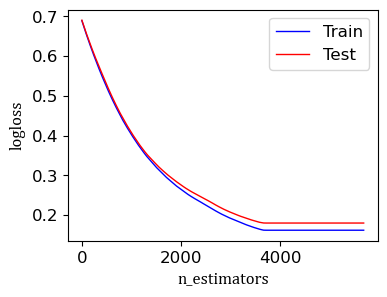

In [20]:
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train', color='blue', linewidth = '1')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test', color='red', linewidth = '1')
ax.legend()
plt.ylabel('logloss',{'fontname':'Cambria'})
plt.xlabel('n_estimators',{'fontname':'Cambria'})
# plt.title('XGBoost logloss', {'fontname':'Cambria'})
plt.show()

In [21]:
y_pred = model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % score)
print('Log-loss: %.3f' % log_loss(y_pred, y_test))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ' , recall_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

from sklearn.metrics import matthews_corrcoef
print('mathews_correlation_coefficient: ', matthews_corrcoef(y_test, y_pred))

[19:45:10] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "silent" } are not used.

Accuracy: 0.951
Log-loss: 1.762
precision:  0.9044117647058824
recall:  1.0
f1_score:  0.9498069498069499
roc_auc_score:  0.9545454545454545
mathews_correlation_coefficient:  0.9067483186469021


Test-Set Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Paired, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix (Test set)', fontsize=18)
plt.show()

Rheinbay Confusion Matrix

Accuracy: 0.804
Log-loss: 7.048
precision:  0.8575851393188855
recall:  0.6739659367396593
f1_score:  0.7547683923705722
roc_auc_score:  0.7918406720008404
mathews_correlation_coefficient:  0.9067483186469021


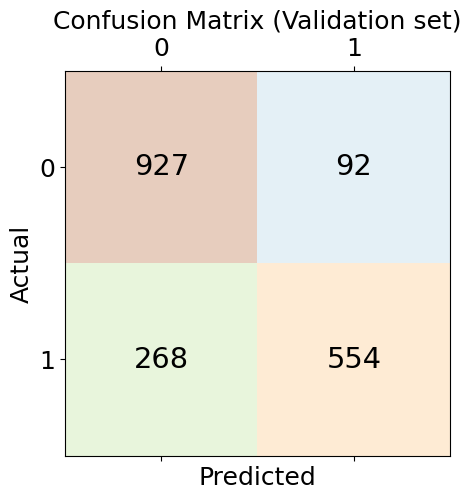

In [22]:
valsetpred = model.predict(data_test[data_test['data_source'] != 'Dr.Nod 2023'][COLUMNS_TRAINING])
valset_y = data_test[data_test['data_source'] != 'Dr.Nod 2023']['driver']
score = accuracy_score(valset_y, valsetpred)
print('Accuracy: %.3f' % score)
print('Log-loss: %.3f' % log_loss(valsetpred, valset_y))
print('precision: ', precision_score(valset_y, valsetpred))
print('recall: ' , recall_score(valset_y, valsetpred))
print('f1_score: ', f1_score(valset_y, valsetpred))
print('roc_auc_score: ', roc_auc_score(valset_y, valsetpred))
print('mathews_correlation_coefficient: ', matthews_corrcoef(y_test, y_pred))

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=valset_y, y_pred=valsetpred)

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Paired, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix (Validation set)', fontsize=18)
plt.show()

Dr.Nod Confusion Matrix

Accuracy: 0.884
Log-loss: 4.179
precision:  0.6166666666666667
recall:  0.751269035532995
f1_score:  0.6773455377574371
roc_auc_score:  0.8304922213975082
mathews_correlation_coefficient:  0.9067483186469021


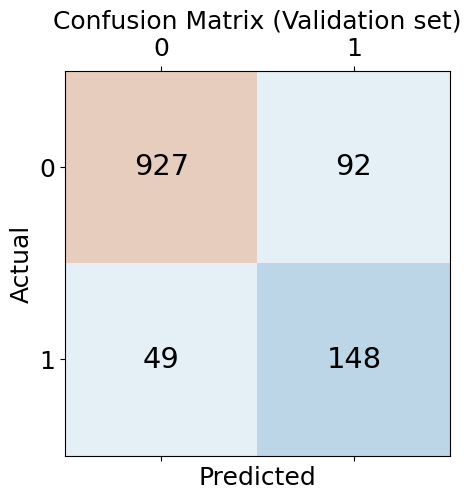

In [23]:
valsetpred = model.predict(data_test[data_test['data_source'] != 'Rheinbay et al 2020'][COLUMNS_TRAINING])
valset_y = data_test[data_test['data_source'] != 'Rheinbay et al 2020']['driver']
score = accuracy_score(valset_y, valsetpred)
print('Accuracy: %.3f' % score)
print('Log-loss: %.3f' % log_loss(valsetpred, valset_y))
print('precision: ', precision_score(valset_y, valsetpred))
print('recall: ' , recall_score(valset_y, valsetpred))
print('f1_score: ', f1_score(valset_y, valsetpred))
print('roc_auc_score: ', roc_auc_score(valset_y, valsetpred))
print('mathews_correlation_coefficient: ', matthews_corrcoef(y_test, y_pred))

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=valset_y, y_pred=valsetpred)

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Paired, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix (Validation set)', fontsize=18)
plt.show()

Some violin plots as experimentation

In [ ]:
valset = data_test.copy()
valset['driver'] = data_test['driver']
valset['predicted'] = valsetpred
valset['result'] = np.where(valset['driver'] == valset['predicted'], 'correct', 'wrong')
valset[['result', 'data_source']].value_counts()

In [ ]:
meltdf = valset[['CTCF_interactions', 'POLR2A_interactions', 'driver', 'result']].melt(id_vars=['result'], value_vars=['CTCF_interactions', 'POLR2A_interactions'])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
meltdf = valset[['ada_score', 'rf_score', 'driver', 'result']].melt(id_vars=['result'], value_vars=['ada_score', 'rf_score'])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
meltdf = valset[['known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream','known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream', 'driver', 'result']].melt(id_vars=['result'], value_vars=['known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream','known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream',])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
meltdf = valset[['SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
                    'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
                    'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', 'driver', 'result']].melt(id_vars=['result'], value_vars=['SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
                    'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
                    'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL'])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
meltdf = valset[['TF_loss_add', 'TF_gain_add', 'TF_loss_diff_add', 'TF_gain_diff_add', 'driver', 'result']].melt(id_vars=['result'], value_vars=['TF_loss_add', 'TF_gain_add', 'TF_loss_diff_add', 'TF_gain_diff_add',])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

SHAP Explainer

In [13]:
x_data = data[COLUMNS_TRAINING]
x_data = x_data.reindex(columns=COLUMNS_TRAINING)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)

In [14]:
for c in COLUMNS_SHAP:
    data[c] = np.nan
data.loc[data.index, COLUMNS_SHAP] = shap_values

In [43]:
# x_data[['splice_acceptor_variant', 'splice_donor_variant', 'promoter', 'downstream_gene_variant', 'regulatory_region_variant']]#.describe()
x_data.columns.get_loc('known_lncrna')
# x_data.columns.get_loc('TF_loss_add')
# x_data.columns.get_loc('LOEUF')
# data['driver'].value_counts()

68

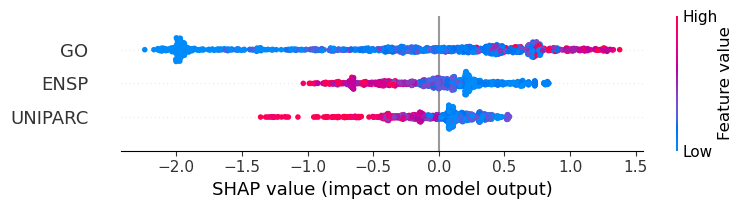

In [26]:
shap.summary_plot(shap_values[:,2:5], x_data.iloc[:, 2:5], plot_size = 0.25)  # protein product
# shap.summary_plot(shap_values[:,5:14], x_data.iloc[:, 5:14], plot_size = 0.25)  # splice ai
# shap.summary_plot(shap_values[:,0:2], x_data.iloc[:, 0:2], plot_size = 0.25) #ada score rf score
# shap.summary_plot(shap_values[:,38:42], x_data.iloc[:, 38:42], plot_size = 0.25)  # interactions
# shap.summary_plot(shap_values[:,47:53], x_data.iloc[:, 47:53], plot_size = 0.25) # cosmic genes
# shap.summary_plot(shap_values[:,42:47], x_data.iloc[:, 42:47], plot_size = 0.25) #repeat masker
# shap.summary_plot(shap_values[:,64:68], x_data.iloc[:, 64:68], plot_size = 0.25)  # tf
# shap.summary_plot(shap_values[:,68:75], x_data.iloc[:, 68:75], plot_size = 0.25)  # lncrna
# shap.summary_plot(shap_values[:,[60, 55, 24, 38, 17, 23]], x_data.iloc[:, [60, 55, 24, 38, 17, 23]], plot_size = 0.25) # the rest
# shap.summary_plot(shap_values[:,[17, 25]], x_data.iloc[:, [17, 25]], plot_size = 0.25) # the rest

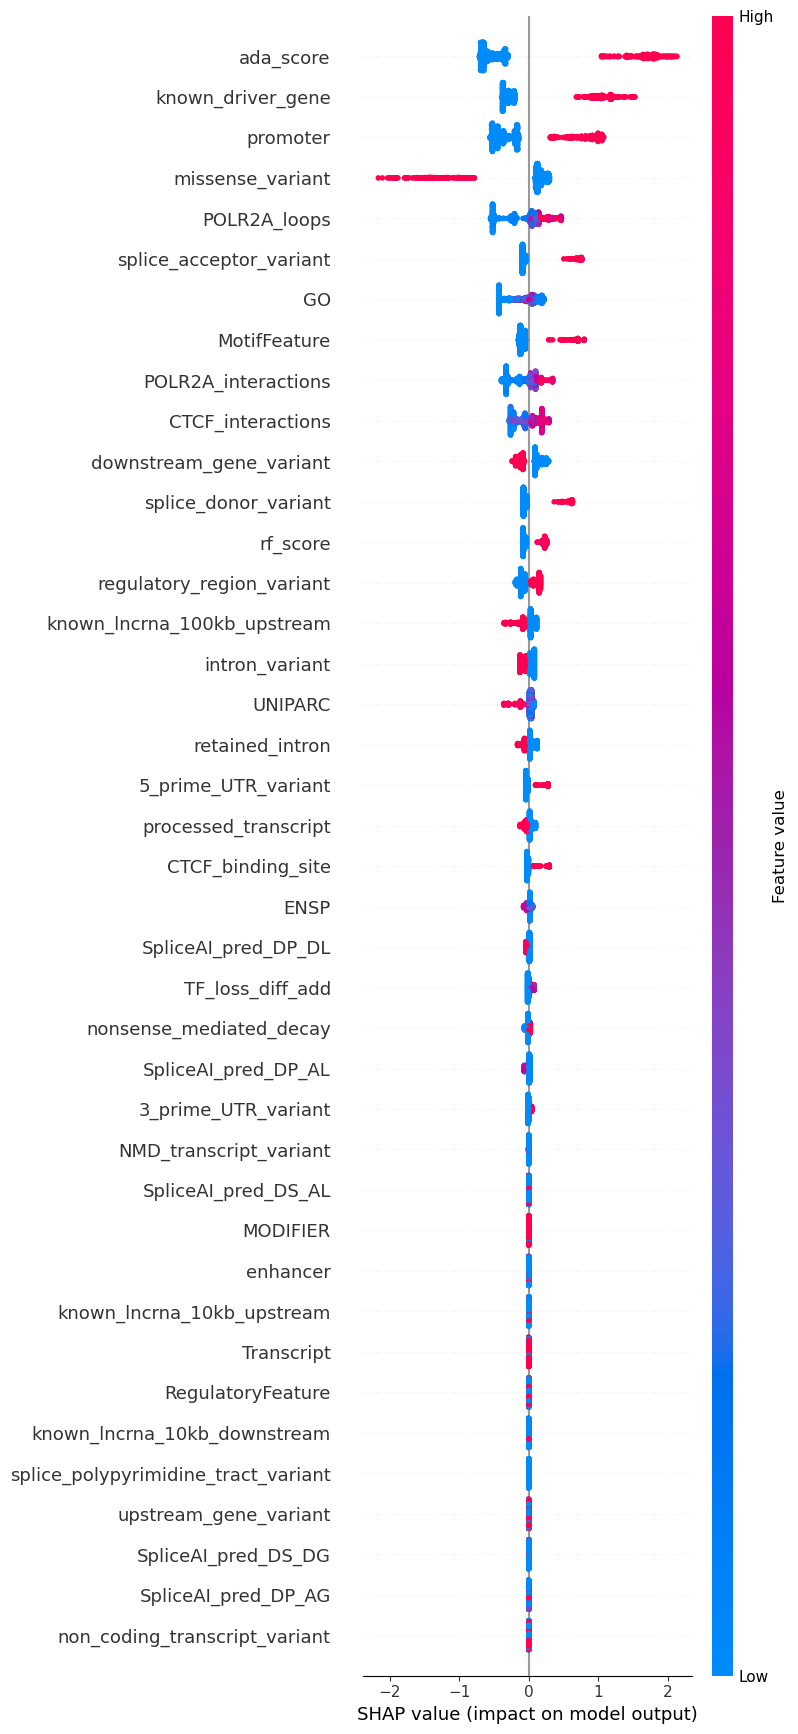

In [15]:
shap.summary_plot(shap_values, x_data, max_display=40)

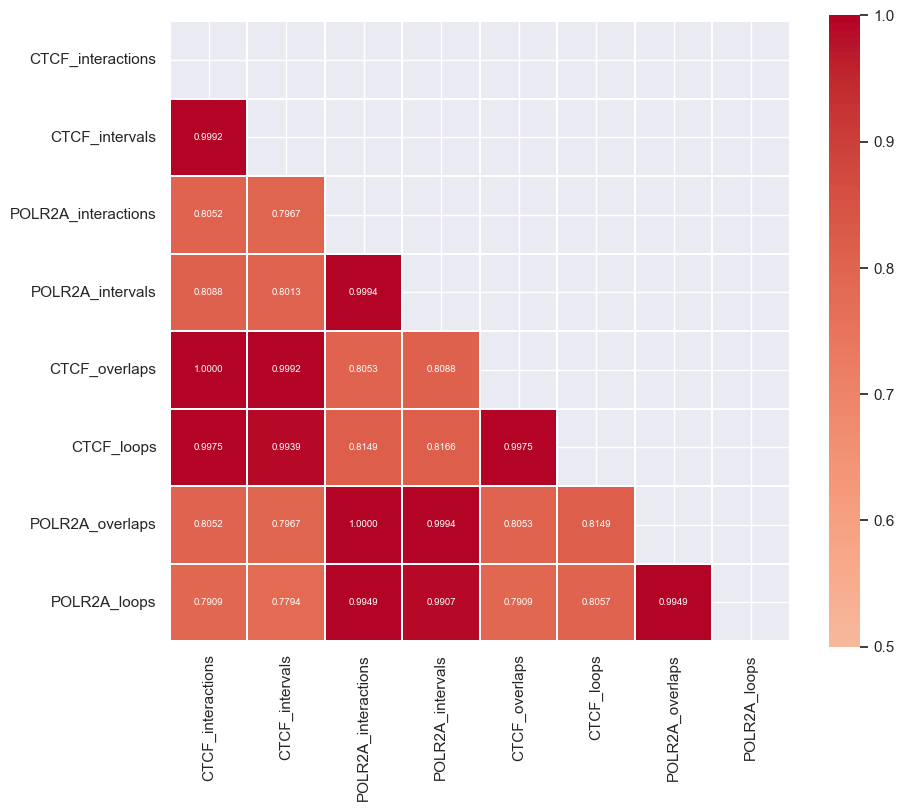

In [32]:
COLUMNS_WITH_DRIVER = COLUMNS_TRAINING
COLUMNS_WITH_DRIVER.append('driver')
corr_matrix = data[['CTCF_interactions', 'CTCF_intervals', 'POLR2A_interactions', 'POLR2A_intervals',
                    'CTCF_overlaps', 'CTCF_loops', 'POLR2A_overlaps', 'POLR2A_loops']].corr()
matrix = np.triu(corr_matrix)
sns.set(font_scale=0.5)
# sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(rc={'figure.figsize':(10,10)})
# sns.set(rc=)

ax= sns.heatmap(corr_matrix, mask=matrix, vmin=0.5, vmax=+1, center=0.25,
            square=True, linewidths=.1, cbar_kws={"shrink": .82},annot=True,
            fmt='.4f',annot_kws={"size":7}, cmap='coolwarm')

sns.set()
for t in ax.texts:
    if float(t.get_text())>=0.4 or float(t.get_text())<=-0.4:
        t.set_text(t.get_text()) #if the value is greater than 0.4 then I set the text 
    else:
        t.set_text("") # if not it sets an empty text

In [ ]:
# shap.dependence_plot("CTCF_interactions", shap_values, x_data, interaction_index="CTCF_chains")
shap.plots.violin(shap_values, feature_names=list(data[COLUMNS_TRAINING].columns), plot_type="violin")

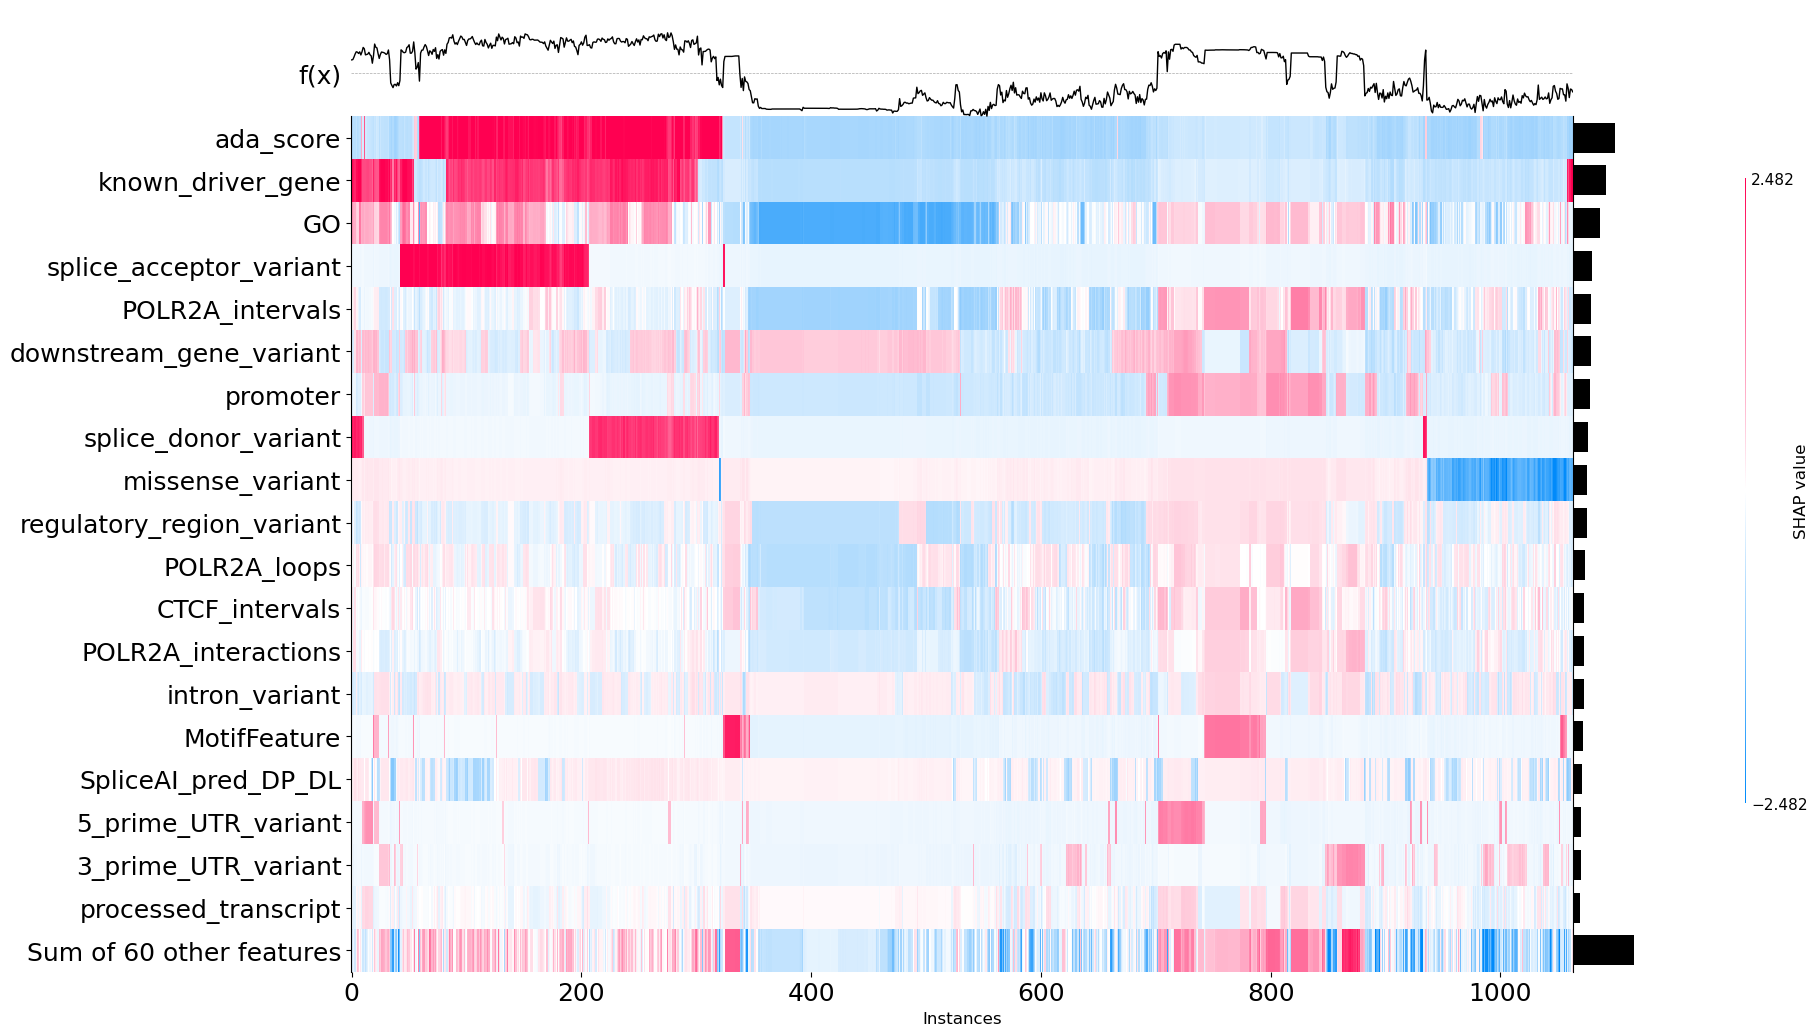

In [15]:
# shap.plots.heatmap(shap_values)
plt.rcParams.update({'font.size': 12})
shap_values_explaination = shap.Explanation(shap_values, feature_names=data[COLUMNS_TRAINING].columns.tolist()) 
shap.plots.heatmap(shap_values_explaination, max_display=20, plot_width=18, show=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [68]:
x_data = data[COLUMNS_TRAINING]
explainer = shap.TreeExplainer(model) # grabbing the first model
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[101:200], x_data[101:200])

<Axes: >

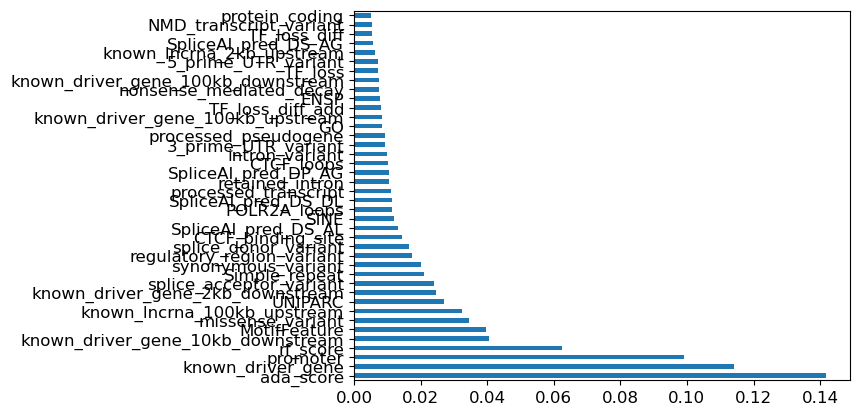

In [81]:
feat_importances = pd.Series(model.feature_importances_, index=data[COLUMNS_TRAINING].columns)
feat_importances.nlargest(40).plot(kind='barh')

SHAP for Validation Set

In [34]:
x_data_test = data_test[COLUMNS_TRAINING]
x_data_test = x_data_test.reindex(columns=COLUMNS_TRAINING)

explainer_test = shap.TreeExplainer(model)
shap_values_test = explainer_test.shap_values(x_data_test)

for c in COLUMNS_SHAP:
    data_test[c] = np.nan
data_test.loc[data_test.index, COLUMNS_SHAP] = shap_values_test

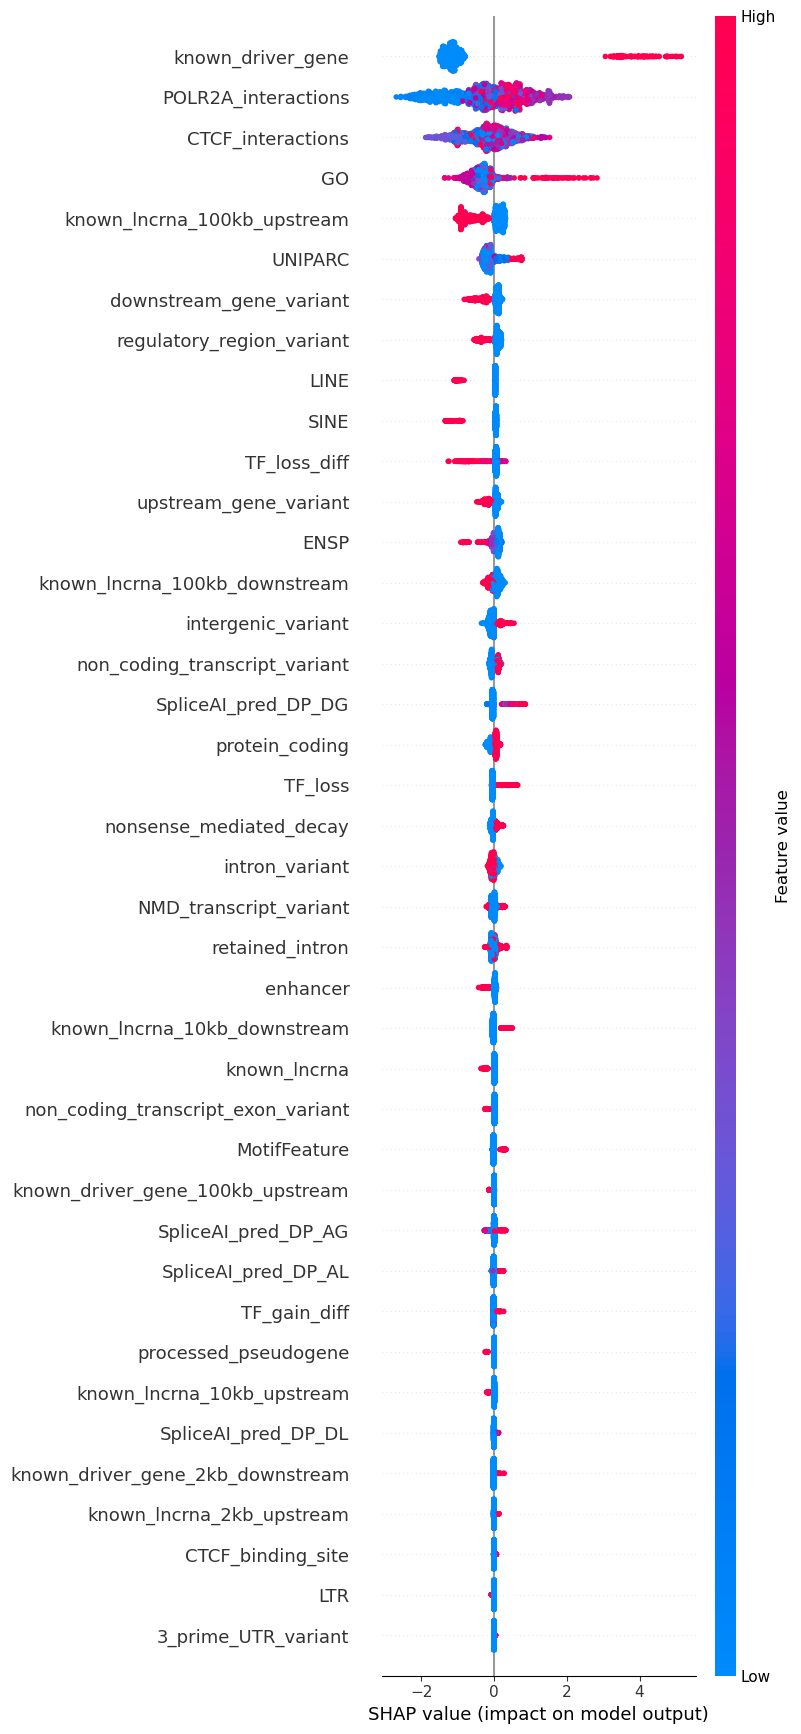

In [35]:
shap.summary_plot(shap_values_test, x_data_test, max_display=40)

In [83]:
data[data['driver'] == 0][['CTCF_interactions']].count()

CTCF_interactions    487
dtype: int64

In [66]:
data[data['driver'] == 1][['CTCF_interactions']].count()

CTCF_interactions    487
dtype: int64

In [5]:
data_test[['data_source']].value_counts()

data_source        
Rheinbay et al 2020    820
Dr.Nod 2023            197
COSMIC                 112
dtype: int64

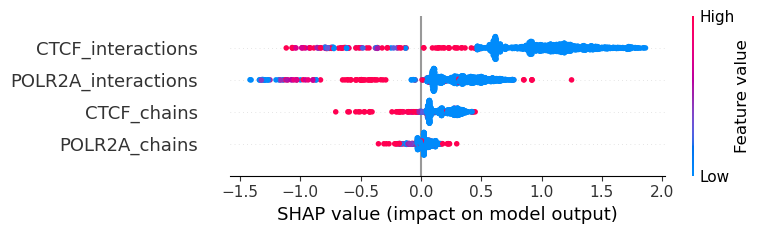

In [124]:
# shap.summary_plot(shap_values_test[:,2:5], x_data_test.iloc[:, 2:5], plot_size = 0.25)  # protein product
# shap.summary_plot(shap_values_test[:,6:14], x_data_test.iloc[:, 6:14], plot_size = 0.25)  # splice ai
# shap.summary_plot(shap_values_test[:,0:2], x_data_test.iloc[:, 0:2], plot_size = 0.25) #ada score rf score
shap.summary_plot(shap_values_test[:,39:43], x_data_test.iloc[:, 39:43], plot_size = 0.25)  # interactions
# shap.summary_plot(shap_values_test[:,[48, 50, 51, 52, 53, 54, 49]], x_data_test.iloc[:, [48, 50, 51, 52, 53, 54, 49]], plot_size = 0.25) # cosmic genes
# shap.summary_plot(shap_values_test[:,43:48], x_data_test.iloc[:, 43:48], plot_size = 0.25) #repeat masker
# shap.summary_plot(shap_values_test[:,65:70], x_data_test.iloc[:, 65:70], plot_size = 0.25)  # tf
# shap.summary_plot(shap_values_test[:,5:6], x_data_test.iloc[:, 5:6], plot_size = 0.25)  # loeuf
# shap.summary_plot(shap_values_test[:,[60, 24, 38, 17, 23]], x_data_test.iloc[:, [60, 24, 38, 17, 23]], plot_size = 0.25) # the rest

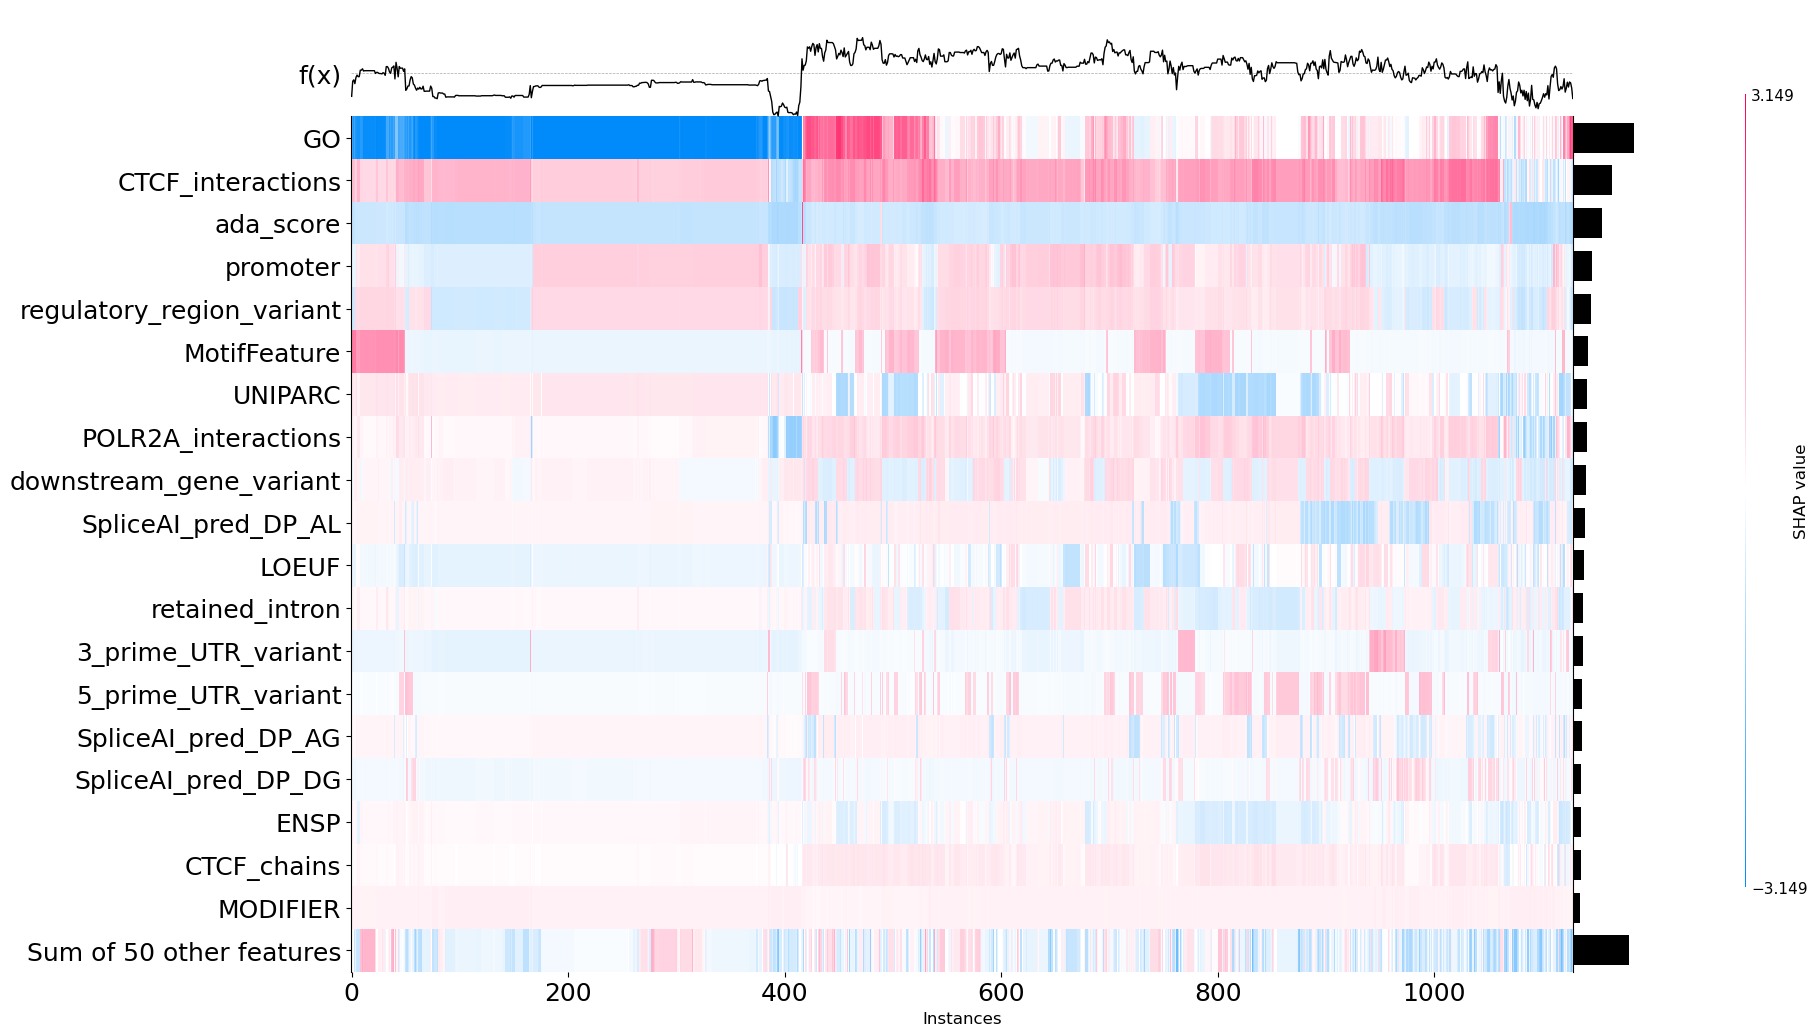

In [125]:
# shap.plots.heatmap(shap_values)
plt.rcParams.update({'font.size': 12})
shap_values_explaination_test = shap.Explanation(shap_values_test, feature_names=data_test[COLUMNS_TRAINING].columns.tolist()) 
shap.plots.heatmap(shap_values_explaination_test, max_display=20, plot_width=18, show=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [126]:
data['driver'].value_counts()

0    487
1    487
Name: driver, dtype: int64

In [127]:
len(data)

974